<a href="https://colab.research.google.com/github/Vineesha2005/B-14_1873_PDS/blob/main/project%20final%20code%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (10000, 15)
   Year Country         Region  Crop_Type  Average_Temperature_C  \
0  2001   India    West Bengal       Corn                   1.55   
1  2024   China          North       Corn                   3.23   
2  2001  France  Ile-de-France      Wheat                  21.11   
3  2001  Canada       Prairies     Coffee                  27.85   
4  1998   India     Tamil Nadu  Sugarcane                   2.19   

   Total_Precipitation_mm  CO2_Emissions_MT  Crop_Yield_MT_per_HA  \
0                  447.06             15.22                 1.737   
1                 2913.57             29.82                 1.737   
2                 1301.74             25.75                 1.719   
3                 1154.36             13.91                 3.890   
4                 1627.48             11.81                 1.080   

   Extreme_Weather_Events  Irrigation_Access_%  Pesticide_Use_KG_per_HA  \
0                       8                14.54                    10.08   

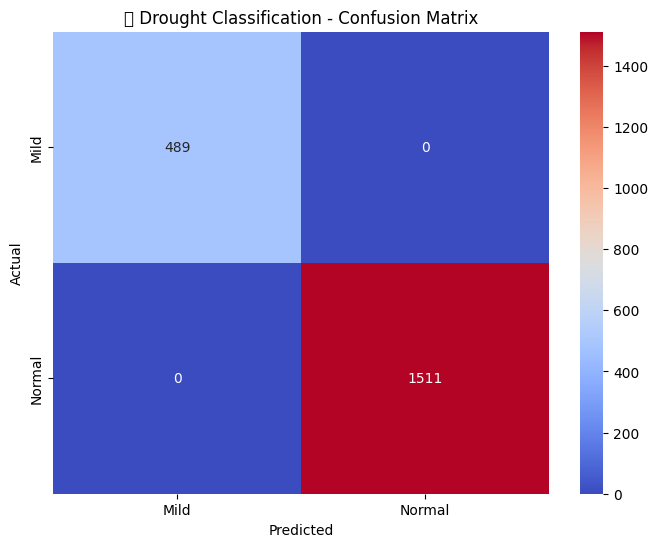

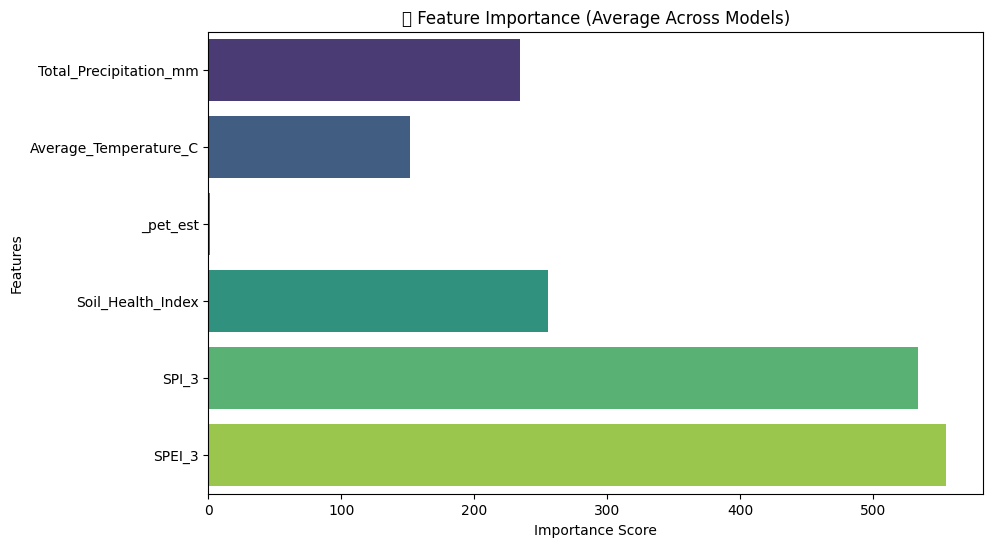

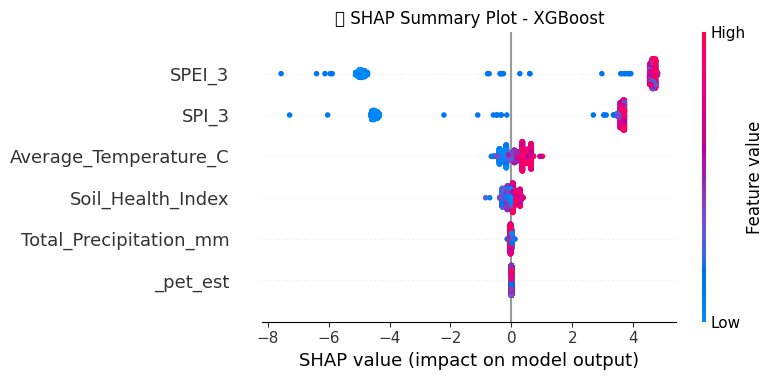

In [4]:
# =========================================================
# 🌦️ Drought Modeling & Risk Assessment - Final Code
# IEEE Paper Implementation - Clean & Optimized
# =========================================================

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# ---------------------- Suppress Warnings ----------------------
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ---------------------- Load Dataset ---------------------------
DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"
df = pd.read_csv(DATA_PATH)
print(f"Dataset Shape: {df.shape}")
print(df.head())

# ---------------------- Auto-Detect Columns ---------------------
def col_like(df, patterns):
    import re
    cols = {c.lower(): c for c in df.columns}
    for p in patterns:
        rx = re.compile(p)
        for lc, orig in cols.items():
            if rx.search(lc):
                return orig
    return None

rain_col  = col_like(df, [r"rain", r"precip", r"ppt"])
temp_col  = col_like(df, [r"temp", r"temperature"])
pet_col   = col_like(df, [r"pet", r"evapo", r"et0"])
soil_col  = col_like(df, [r"soil", r"soil_health", r"moisture"])
yield_col = col_like(df, [r"yield", r"production"])

# ---------------------- Clean Numeric Columns --------------------
def safe_num(df, col):
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())
    return df

for c in [rain_col, temp_col, pet_col, soil_col, yield_col]:
    if c:
        df = safe_num(df, c)

# Estimate PET if missing
if not pet_col:
    df["_pet_est"] = 0.6 * df[temp_col].fillna(0.0)
    pet_col = "_pet_est"

# ---------------------- Feature Engineering ----------------------
def rolling_z(arr, window=3):
    s = pd.Series(arr)
    mean = s.rolling(window, min_periods=1).mean()
    std = s.rolling(window, min_periods=1).std(ddof=0).replace(0, s.std(ddof=0))
    return ((s - mean) / (std + 1e-9)).fillna(0.0).values

df["SPI_3"] = rolling_z(df[rain_col].values, window=3)
df["SPEI_3"] = rolling_z(df[rain_col].values - df[pet_col].values, window=3)

# ---------------------- Drought Labels ---------------------------
def drought_label(spi, spei):
    v = min(spi, spei)
    if v <= -2.0: return "Severe"
    if v <= -1.5: return "Moderate"
    if v <= -1.0: return "Mild"
    return "Normal"

df["drought_severity"] = [drought_label(a, b) for a, b in zip(df["SPI_3"], df["SPEI_3"])]

# ---------------------- Feature Selection ------------------------
features = [rain_col, temp_col, pet_col, soil_col, "SPI_3", "SPEI_3"]
features = [f for f in features if f in df.columns]

X = df[features].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["drought_severity"])

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ---------------------- Split Data ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------- Ensemble Model --------------------------
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
lgbm = LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    min_gain_to_split=0, verbosity=-1, random_state=42
)
cat = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=0)

estimators = [
    ("xgb", xgb),
    ("lgbm", lgbm),
    ("cat", cat),
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500),
    cv=5,
    n_jobs=-1
)

# Train & Predict
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)

# ---------------------- Evaluation Metrics -----------------------
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Model Accuracy: {acc:.4f}")

class_labels = list(label_encoder.classes_)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_labels))

# ---------------------- Confusion Matrix ------------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("🌦️ Drought Classification - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------- Feature Importance ----------------------
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
cat.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
importance = np.mean([
    xgb.feature_importances_,
    lgbm.feature_importances_,
    cat.feature_importances_
], axis=0)

sns.barplot(x=importance, y=features, palette="viridis")
plt.title("🌟 Feature Importance (Average Across Models)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# ---------------------- SHAP Explainability ---------------------
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

plt.title("🔍 SHAP Summary Plot - XGBoost")
shap.summary_plot(shap_values, X_test, feature_names=features)
